In [9]:
import pandas as pd
import numpy as np
import os
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import ast
from tqdm import tqdm
from itertools import product
from sklearn.manifold import TSNE

import matplotlib.cm as cm
import matplotlib.colors as colors

os.chdir('D:/Jiang/Research_Anomaly Detection/ADSD')

from data_generator import DataGenerator
from myutils import Utils
utils = Utils()

# from other_utils.utils import draw_cd_diagram

import warnings
warnings.filterwarnings("ignore")

In [10]:
def collect_result(metric, la, model_pool, dataset_list_intersection=None):
    
    # baseline
    result_baseline_unsup = pd.read_csv(os.path.join('result', 'new', metric + '_ADSD_baseline_unsup_duplicates(True).csv'))
    result_baseline_semi = pd.read_csv(os.path.join('result', 'new', metric + '_ADSD_baseline_semi_duplicates(True).csv'))
    result_baseline_sup = pd.read_csv(os.path.join('result', 'new', metric + '_ADSD_baseline_sup_duplicates(True).csv'))
    
    # REPEN (currently something wrong)
    result_baseline_semi.drop(['REPEN'], axis=1, inplace=True)
    result_REPEN = pd.read_csv(os.path.join('result', 'old', 'baseline', metric + '_test.csv'))
    result_REPEN = result_REPEN[['Unnamed: 0', 'REPEN']]
    
    # 需要对齐的数据集
    d_align = list(set([ast.literal_eval(_)[0] for _ in result_baseline_semi['Unnamed: 0']]))
    for i in tqdm(range(result_REPEN.shape[0])):
        params = ast.literal_eval(result_REPEN.loc[i, 'Unnamed: 0'])
        d = params[0].replace('.diff', '')
        d = d.split('_')[0]
        d_revise = [_ for _ in d_align if d == _.split('_')[1]]

        if len(d_revise) == 1:
            result_REPEN.loc[i, 'Unnamed: 0'] = str((d_revise[0], params[1], params[2]))
        else:
#             print(d)
            pass
    
    
    # DualGAN
    result_DualGAN = pd.read_csv(os.path.join('result', 'new', metric + '_ADSD_baseline_DualGAN_duplicates(True).csv'))
    
    # MLP (supervised)
#     result_MLP = pd.read_csv(os.path.join('result', metric + '_ADSD_add_baseline_sup_duplicates(True).csv'))
#     result_MLP.rename(columns={'FS':'MLP'}, inplace=True)
    
    # ADSD based on MLP
    result_ADSD_MLP = pd.read_csv(os.path.join('result', 'new', metric + '_ADSD_proposed_MLP_duplicates(True).csv'))
    result_ADSD_MLP.rename(columns={'ADSD':'ADSD_MLP'}, inplace=True)
    # ADSD based on AEpro
    result_ADSD_AEpro = pd.read_csv(os.path.join('result', 'new', metric + '_ADSD_proposed_AEpro_duplicates(True).csv'))
    result_ADSD_AEpro.rename(columns={'ADSD':'ADSD_AEpro'}, inplace=True)
    # ADSD based on  ResNet
    result_ADSD_ResNet = pd.read_csv(os.path.join('result', 'new', metric + '_ADSD_epoch(100)_es(True)_proposed_ResNet_duplicates(True).csv'))
    result_ADSD_ResNet.rename(columns={'ADSD':'ADSD_ResNet'}, inplace=True)
    # ADSD based on FTTransformer
    result_ADSD_FT = pd.read_csv(os.path.join('result', 'new', metric + '_ADSD_epoch(100)_es(True)_bw(0.1)_proposed_FTTransformer_duplicates(True).csv'))
    result_ADSD_FT.rename(columns={'ADSD':'ADSD_FTTransformer'}, inplace=True)
    # ADSD based on DeepSAD
    result_ADSD_DeepSAD = pd.read_csv(os.path.join('result', 'new', metric + '_ADSD_proposed_DeepSAD_duplicates(True).csv'))
    result_ADSD_DeepSAD.rename(columns={'ADSD':'ADSD_DeepSAD'}, inplace=True)
    
    # merge results
    result = result_baseline_unsup.merge(result_baseline_semi, how='left', on='Unnamed: 0')
    result = result.merge(result_baseline_sup, how='left', on='Unnamed: 0')
    result = result.merge(result_REPEN, how='left', on='Unnamed: 0')
    result = result.merge(result_DualGAN, how='left', on='Unnamed: 0')
#     result = result.merge(result_MLP, how='left', on='Unnamed: 0')
    
    result = result.merge(result_ADSD_MLP, how='left', on='Unnamed: 0')
    result = result.merge(result_ADSD_AEpro, how='left', on='Unnamed: 0')
    result = result.merge(result_ADSD_ResNet, how='left', on='Unnamed: 0')
    result = result.merge(result_ADSD_FT, how='left', on='Unnamed: 0')
    result = result.merge(result_ADSD_DeepSAD, how='left', on='Unnamed: 0')
    

    result.rename(columns={'Unnamed: 0':'Params'}, inplace=True)
    
    #整合多次实验结果
    result = result.loc[[ast.literal_eval(_)[1]==la for _ in result['Params']]]
    datasets = list(set([ast.literal_eval(_)[0] for _ in result['Params']]))

    result_show = pd.DataFrame(data=None, index=datasets, columns=result.columns[1:])

    for i,dataset in enumerate(result_show.index):
        #注意这里包含了nan的mean,比如一个模型跑5次实验,其中有一次挂了,在剩余4次有效实验中求平均
        ave_metric = np.nanmean(result.iloc[[ast.literal_eval(_)[0] == dataset for _ in result['Params']],1:], axis=0)
        result_show.iloc[i,:] = ave_metric
        
    # 选择比较的模型
    model_pool = [_ for _ in model_pool if _ in result_show.columns]
    result_show = result_show[model_pool]
    
    # 选择数据集
    data_generator = DataGenerator(generate_duplicates=False, n_samples_threshold=1000)
    
    # 去除样本过少(< 1000)的数据集
    dataset_list = []
    for _ in result_show.index:
        data_generator.seed = 42
        data_generator.dataset = _
        
        data = data_generator.generator(la=1.00)
        if len(data['y_train']) + len(data['y_test']) > 1000:
            dataset_list.append(_)
        else:
            print(f'数据集{_}被移除,样本过少\n')
            
    # exclude 庞老师的数据集
    dataset_list = [_ for _ in dataset_list if _ not in ['3_backdoor', '9_census', '8_celeba', '11_donors', '5_campaign', '13_fraud']]
            
    result_show = result_show.loc[dataset_list, :]
    
    # 有无提供选定的数据集
    if dataset_list_intersection is not None:
        result_show = result_show.loc[dataset_list_intersection, :]
            
    # 输出没有实验结果的数据集+模型
    for i, dataset in enumerate(result_show.index):
        if any(result_show.isna().iloc[i, :].values):
            print(f'Dataset: {dataset}, NaN Model: {list(result_show.columns[result_show.isna().iloc[i, :].values])}')

    #去除没有实验结果的数据集
    result_show.dropna(inplace=True, axis=0)
    
    return result_show

def result_process_final(result_show, name):
    perf = ((result_show.loc[name, 'Perf.'] - result_show.loc[:, 'Perf.']) / result_show.loc[:, 'Perf.']).values
    star = []

    for _ in result_show['p-value']:
        _ = float(_)
        if _ <= 0.01:
            star.append('***')
        elif _ > 0.01 and _ <= 0.05:
            star.append('**')
        elif _ > 0.05 and _ <= 0.1:
            star.append('*')
        else:
            star.append('')
    
    perf = ['+'+str(format(round(_*100, 2), '.2f'))+'%' if _ >= 0 else '-'+str(format(round(_*100, 2), '.2f'))+'%' for _ in perf]
    
    result_show['Perf.'] = [a+b for a, b in zip(perf, star)]
    
    return result_show[['Ave.metric', 'Perf.']]

In [11]:
metric = 'AUCPR'
la_list = [0.05, 0.10, 0.20]

# 对齐数据集
model_pool = ['IForest', 'ECOD', 'DeepSVDD',
              'GANomaly', 'DeepSAD', 'REPEN', 'DevNet', 'PReNet', 'MLP',
              'FEAWAD', 'FS', 'ResNet', 'FTTransformer',
              'ADSD_MLP', 'ADSD_AEpro', 'ADSD_ResNet', 'ADSD_FTTransformer']

result_show_list = []
dataset_list_intersection = []
for n, la in enumerate(la_list):
    result_show = collect_result(metric, la, model_pool)
    dataset_list_intersection.append(list(result_show.index))
    print(f'共有{result_show.shape[0]}个数据集, {result_show.shape[1]}个模型')
    
    dataset_list = list(result_show.index)
    
    result_show = result_show.reindex(sorted(result_show.index, key=lambda x: x.lower()))
    result_show = utils.result_process_new(result_show, 'ADSD_MLP', std=True)
    
    result_show = result_show.loc[['Perf.', 'Ave.metric', 'p-value'],:]
    result_show = result_show.transpose()
    result_show = result_process_final(result_show, 'ADSD_MLP')
    
    result_show.columns = [_ + '_' +str(la) for _ in result_show.columns]
    result_show_list.append(result_show)

100%|██████████████████████████████████████████████████████████████████████████████| 465/465 [00:00<00:00, 4807.44it/s]


{'Samples': 5393, 'Features': 10, 'Anomalies': 510, 'Anomalies Ratio(%)': 9.46}


FileNotFoundError: [Errno 2] No such file or directory: 'datasets\\13_fraud.npz'

In [ ]:
dataset_list_intersection = list(set.intersection(*map(set, dataset_list_intersection)))

In [ ]:
print(len(dataset_list_intersection))

## ADSD-MLP

In [25]:
model_pool = ['IForest', 'ECOD', 'DeepSVDD',
              'GANomaly', 'DeepSAD', 'REPEN', 'DevNet', 'PReNet',
              'ADSD_MLP']

result_show_list = []
for n,la in enumerate(la_list):
    result_show = collect_result(metric, la, model_pool, dataset_list_intersection=dataset_list_intersection)
    print(f'共有{result_show.shape[0]}个数据集, {result_show.shape[1]}个模型')
    
    dataset_list = list(result_show.index)
    
    result_show = result_show.reindex(sorted(result_show.index, key=lambda x: x.lower()))
    result_show = utils.result_process_new(result_show, 'ADSD_MLP', std=True)
    
    result_show = result_show.loc[['Perf.', 'Ave.metric', 'p-value'],:]
    result_show = result_show.transpose()
    result_show = result_process_final(result_show, 'ADSD_MLP')
    
    result_show.columns = [_ + '_' +str(la) for _ in result_show.columns]
    result_show_list.append(result_show)
    
result = pd.concat(result_show_list, axis=1)
result.to_csv(os.path.join(os.getcwd(), 'result', metric + '-ADSD-MLP.csv'), index=True, encoding='gbk')

result

100%|██████████████████████████████████████████████████████████████████████████████| 465/465 [00:00<00:00, 4019.28it/s]


数据集16_http数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 3, 'Anomalies': 54, 'Anomalies Ratio(%)': 0.54}
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
{'Samples': 2114, 'Features': 21, 'Anomalies': 466, 'Anomalies Ratio(%)': 22.04}
{'Samples': 129, 'Features': 13, 'Anomalies': 10, 'Anomalies Ratio(%)': 7.75}
数据集45_wine被移除,样本过少

{'Samples': 3443, 'Features': 21, 'Anomalies': 100, 'Anomalies Ratio(%)': 2.9}
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
数据集23_mammography数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 6, 'Anomalies': 226, 'Anomalies Ratio(%)': 2.26}
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
{'Samples': 198, 'Features': 33, 'Anomalies': 47, 'Anomalies Ratio(%)': 23.74}
数据集46_WPBC被移除,样本过少

{'Samples': 5803, 'Features': 36, 'Anomalies': 71, 'Anomalies Ratio(%)': 1.22}
{'Samples': 367, 'Features': 30, 'Anomalies': 10, 'Anomalies Ratio(%)': 2.72}
数据集43_WDBC被移除,样本过少

{'Samples': 6

100%|██████████████████████████████████████████████████████████████████████████████| 465/465 [00:00<00:00, 4088.68it/s]


数据集16_http数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 3, 'Anomalies': 54, 'Anomalies Ratio(%)': 0.54}
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
{'Samples': 2114, 'Features': 21, 'Anomalies': 466, 'Anomalies Ratio(%)': 22.04}
{'Samples': 129, 'Features': 13, 'Anomalies': 10, 'Anomalies Ratio(%)': 7.75}
数据集45_wine被移除,样本过少

{'Samples': 3443, 'Features': 21, 'Anomalies': 100, 'Anomalies Ratio(%)': 2.9}
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
数据集23_mammography数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 6, 'Anomalies': 226, 'Anomalies Ratio(%)': 2.26}
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
{'Samples': 198, 'Features': 33, 'Anomalies': 47, 'Anomalies Ratio(%)': 23.74}
数据集46_WPBC被移除,样本过少

{'Samples': 5803, 'Features': 36, 'Anomalies': 71, 'Anomalies Ratio(%)': 1.22}
{'Samples': 367, 'Features': 30, 'Anomalies': 10, 'Anomalies Ratio(%)': 2.72}
数据集43_WDBC被移除,样本过少

{'Samples': 6

100%|██████████████████████████████████████████████████████████████████████████████| 465/465 [00:00<00:00, 4238.60it/s]


数据集16_http数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 3, 'Anomalies': 54, 'Anomalies Ratio(%)': 0.54}
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
{'Samples': 2114, 'Features': 21, 'Anomalies': 466, 'Anomalies Ratio(%)': 22.04}
{'Samples': 129, 'Features': 13, 'Anomalies': 10, 'Anomalies Ratio(%)': 7.75}
数据集45_wine被移除,样本过少

{'Samples': 3443, 'Features': 21, 'Anomalies': 100, 'Anomalies Ratio(%)': 2.9}
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
数据集23_mammography数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 6, 'Anomalies': 226, 'Anomalies Ratio(%)': 2.26}
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
{'Samples': 198, 'Features': 33, 'Anomalies': 47, 'Anomalies Ratio(%)': 23.74}
数据集46_WPBC被移除,样本过少

{'Samples': 5803, 'Features': 36, 'Anomalies': 71, 'Anomalies Ratio(%)': 1.22}
{'Samples': 367, 'Features': 30, 'Anomalies': 10, 'Anomalies Ratio(%)': 2.72}
数据集43_WDBC被移除,样本过少

{'Samples': 6

,Ave.metric_0.05,Perf._0.05,Ave.metric_0.1,Perf._0.1,Ave.metric_0.2,Perf._0.2
IForest,0.389±0.295,+60.21%***,0.389±0.295,+73.26%***,0.389±0.295,+78.91%***
ECOD,0.315±0.239,+97.83%***,0.315±0.239,+113.95%***,0.315±0.239,+120.92%***
DeepSVDD,0.147±0.120,+325.33%***,0.147±0.120,+359.98%***,0.147±0.120,+374.96%***
GANomaly,0.297±0.191,+109.80%***,0.296±0.195,+127.65%***,0.306±0.201,+127.78%***
DeepSAD,0.506±0.253,+23.27%***,0.601±0.275,+12.06%***,0.675±0.284,+3.04%
REPEN,0.560±0.300,+11.38%**,0.603±0.308,+11.74%**,0.639±0.306,+8.85%
DevNet,0.606±0.311,+2.89%,0.626±0.307,+7.75%**,0.652±0.305,+6.74%*
PReNet,0.612±0.305,+1.82%,0.638±0.307,+5.67%*,0.660±0.303,+5.49%
ADSD_MLP,0.623±0.291,+0.00%,0.674±0.286,+0.00%,0.696±0.288,+0.00%


## ADSD-AEpro

In [26]:
model_pool = ['FEAWAD', 'FS','ADSD_AEpro']

result_show_list = []
for n,la in enumerate(la_list):
    result_show = collect_result(metric, la, model_pool, dataset_list_intersection)
    print(f'共有{result_show.shape[0]}个数据集, {result_show.shape[1]}个模型')
    
    dataset_list = list(result_show.index)
    
    result_show = result_show.reindex(sorted(result_show.index, key=lambda x: x.lower()))
    result_show = utils.result_process_new(result_show, 'ADSD_AEpro', std=True)
    
    result_show = result_show.loc[['Perf.', 'Ave.metric', 'p-value'],:]
    result_show = result_show.transpose()
    result_show = result_process_final(result_show, 'ADSD_AEpro')
    
    result_show.columns = [_ + '_' +str(la) for _ in result_show.columns]
    result_show_list.append(result_show)
    
result = pd.concat(result_show_list, axis=1)
result.to_csv(os.path.join(os.getcwd(), 'result', metric + '-ADSD-AEpro.csv'), index=True, encoding='gbk')

result

100%|██████████████████████████████████████████████████████████████████████████████| 465/465 [00:00<00:00, 4239.81it/s]


数据集16_http数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 3, 'Anomalies': 54, 'Anomalies Ratio(%)': 0.54}
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
{'Samples': 2114, 'Features': 21, 'Anomalies': 466, 'Anomalies Ratio(%)': 22.04}
{'Samples': 129, 'Features': 13, 'Anomalies': 10, 'Anomalies Ratio(%)': 7.75}
数据集45_wine被移除,样本过少

{'Samples': 3443, 'Features': 21, 'Anomalies': 100, 'Anomalies Ratio(%)': 2.9}
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
数据集23_mammography数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 6, 'Anomalies': 226, 'Anomalies Ratio(%)': 2.26}
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
{'Samples': 198, 'Features': 33, 'Anomalies': 47, 'Anomalies Ratio(%)': 23.74}
数据集46_WPBC被移除,样本过少

{'Samples': 5803, 'Features': 36, 'Anomalies': 71, 'Anomalies Ratio(%)': 1.22}
{'Samples': 367, 'Features': 30, 'Anomalies': 10, 'Anomalies Ratio(%)': 2.72}
数据集43_WDBC被移除,样本过少

{'Samples': 6

100%|██████████████████████████████████████████████████████████████████████████████| 465/465 [00:00<00:00, 3642.58it/s]


数据集16_http数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 3, 'Anomalies': 54, 'Anomalies Ratio(%)': 0.54}
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
{'Samples': 2114, 'Features': 21, 'Anomalies': 466, 'Anomalies Ratio(%)': 22.04}
{'Samples': 129, 'Features': 13, 'Anomalies': 10, 'Anomalies Ratio(%)': 7.75}
数据集45_wine被移除,样本过少

{'Samples': 3443, 'Features': 21, 'Anomalies': 100, 'Anomalies Ratio(%)': 2.9}
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
数据集23_mammography数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 6, 'Anomalies': 226, 'Anomalies Ratio(%)': 2.26}
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
{'Samples': 198, 'Features': 33, 'Anomalies': 47, 'Anomalies Ratio(%)': 23.74}
数据集46_WPBC被移除,样本过少

{'Samples': 5803, 'Features': 36, 'Anomalies': 71, 'Anomalies Ratio(%)': 1.22}
{'Samples': 367, 'Features': 30, 'Anomalies': 10, 'Anomalies Ratio(%)': 2.72}
数据集43_WDBC被移除,样本过少

{'Samples': 6

100%|██████████████████████████████████████████████████████████████████████████████| 465/465 [00:00<00:00, 4200.38it/s]


数据集16_http数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 3, 'Anomalies': 54, 'Anomalies Ratio(%)': 0.54}
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
{'Samples': 2114, 'Features': 21, 'Anomalies': 466, 'Anomalies Ratio(%)': 22.04}
{'Samples': 129, 'Features': 13, 'Anomalies': 10, 'Anomalies Ratio(%)': 7.75}
数据集45_wine被移除,样本过少

{'Samples': 3443, 'Features': 21, 'Anomalies': 100, 'Anomalies Ratio(%)': 2.9}
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
数据集23_mammography数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 6, 'Anomalies': 226, 'Anomalies Ratio(%)': 2.26}
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
{'Samples': 198, 'Features': 33, 'Anomalies': 47, 'Anomalies Ratio(%)': 23.74}
数据集46_WPBC被移除,样本过少

{'Samples': 5803, 'Features': 36, 'Anomalies': 71, 'Anomalies Ratio(%)': 1.22}
{'Samples': 367, 'Features': 30, 'Anomalies': 10, 'Anomalies Ratio(%)': 2.72}
数据集43_WDBC被移除,样本过少

{'Samples': 6

,Ave.metric_0.05,Perf._0.05,Ave.metric_0.1,Perf._0.1,Ave.metric_0.2,Perf._0.2
FEAWAD,0.596±0.286,+9.29%***,0.645±0.293,+7.71%***,0.682±0.283,+4.56%**
FS,0.509±0.269,+28.04%***,0.620±0.270,+12.05%***,0.678±0.270,+5.17%**
ADSD_AEpro,0.652±0.290,+0.00%,0.695±0.294,+0.00%,0.713±0.296,+0.00%


## ADSD-ResNet

In [27]:
model_pool = ['ResNet','ADSD_ResNet']

result_show_list = []
for n,la in enumerate(la_list):
    result_show = collect_result(metric, la, model_pool, dataset_list_intersection)
    print(f'共有{result_show.shape[0]}个数据集, {result_show.shape[1]}个模型')
    
    dataset_list = list(result_show.index)
    
    result_show = result_show.reindex(sorted(result_show.index, key=lambda x: x.lower()))
    result_show = utils.result_process_new(result_show, 'ADSD_ResNet', std=True)
    
    result_show = result_show.loc[['Perf.', 'Ave.metric', 'p-value'],:]
    result_show = result_show.transpose()
    result_show = result_process_final(result_show, 'ADSD_ResNet')
    
    
    result_show.columns = [_ + '_' +str(la) for _ in result_show.columns]
    result_show_list.append(result_show)
    
result = pd.concat(result_show_list, axis=1)
result.to_csv(os.path.join(os.getcwd(), 'result', metric + '-ADSD-ResNet.csv'), index=True, encoding='gbk')

result

100%|██████████████████████████████████████████████████████████████████████████████| 465/465 [00:00<00:00, 4238.59it/s]


数据集16_http数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 3, 'Anomalies': 54, 'Anomalies Ratio(%)': 0.54}
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
{'Samples': 2114, 'Features': 21, 'Anomalies': 466, 'Anomalies Ratio(%)': 22.04}
{'Samples': 129, 'Features': 13, 'Anomalies': 10, 'Anomalies Ratio(%)': 7.75}
数据集45_wine被移除,样本过少

{'Samples': 3443, 'Features': 21, 'Anomalies': 100, 'Anomalies Ratio(%)': 2.9}
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
数据集23_mammography数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 6, 'Anomalies': 226, 'Anomalies Ratio(%)': 2.26}
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
{'Samples': 198, 'Features': 33, 'Anomalies': 47, 'Anomalies Ratio(%)': 23.74}
数据集46_WPBC被移除,样本过少

{'Samples': 5803, 'Features': 36, 'Anomalies': 71, 'Anomalies Ratio(%)': 1.22}
{'Samples': 367, 'Features': 30, 'Anomalies': 10, 'Anomalies Ratio(%)': 2.72}
数据集43_WDBC被移除,样本过少

{'Samples': 6

100%|██████████████████████████████████████████████████████████████████████████████| 465/465 [00:00<00:00, 4126.01it/s]


数据集16_http数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 3, 'Anomalies': 54, 'Anomalies Ratio(%)': 0.54}
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
{'Samples': 2114, 'Features': 21, 'Anomalies': 466, 'Anomalies Ratio(%)': 22.04}
{'Samples': 129, 'Features': 13, 'Anomalies': 10, 'Anomalies Ratio(%)': 7.75}
数据集45_wine被移除,样本过少

{'Samples': 3443, 'Features': 21, 'Anomalies': 100, 'Anomalies Ratio(%)': 2.9}
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
数据集23_mammography数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 6, 'Anomalies': 226, 'Anomalies Ratio(%)': 2.26}
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
{'Samples': 198, 'Features': 33, 'Anomalies': 47, 'Anomalies Ratio(%)': 23.74}
数据集46_WPBC被移除,样本过少

{'Samples': 5803, 'Features': 36, 'Anomalies': 71, 'Anomalies Ratio(%)': 1.22}
{'Samples': 367, 'Features': 30, 'Anomalies': 10, 'Anomalies Ratio(%)': 2.72}
数据集43_WDBC被移除,样本过少

{'Samples': 6

100%|██████████████████████████████████████████████████████████████████████████████| 465/465 [00:00<00:00, 4162.97it/s]


数据集16_http数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 3, 'Anomalies': 54, 'Anomalies Ratio(%)': 0.54}
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
{'Samples': 2114, 'Features': 21, 'Anomalies': 466, 'Anomalies Ratio(%)': 22.04}
{'Samples': 129, 'Features': 13, 'Anomalies': 10, 'Anomalies Ratio(%)': 7.75}
数据集45_wine被移除,样本过少

{'Samples': 3443, 'Features': 21, 'Anomalies': 100, 'Anomalies Ratio(%)': 2.9}
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
数据集23_mammography数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 6, 'Anomalies': 226, 'Anomalies Ratio(%)': 2.26}
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
{'Samples': 198, 'Features': 33, 'Anomalies': 47, 'Anomalies Ratio(%)': 23.74}
数据集46_WPBC被移除,样本过少

{'Samples': 5803, 'Features': 36, 'Anomalies': 71, 'Anomalies Ratio(%)': 1.22}
{'Samples': 367, 'Features': 30, 'Anomalies': 10, 'Anomalies Ratio(%)': 2.72}
数据集43_WDBC被移除,样本过少

{'Samples': 6

,Ave.metric_0.05,Perf._0.05,Ave.metric_0.1,Perf._0.1,Ave.metric_0.2,Perf._0.2
ResNet,0.401±0.241,+56.30%***,0.483±0.224,+44.81%***,0.598±0.235,+23.92%***
ADSD_ResNet,0.627±0.297,+0.00%,0.699±0.289,+0.00%,0.742±0.283,+0.00%


## ADSD-FTTransformer

In [28]:
model_pool = ['FTTransformer','ADSD_FTTransformer']

result_show_list = []
for n,la in enumerate(la_list):
    result_show = collect_result(metric, la, model_pool, dataset_list_intersection)
    print(f'共有{result_show.shape[0]}个数据集, {result_show.shape[1]}个模型')
    
    dataset_list = list(result_show.index)
    
    result_show = result_show.reindex(sorted(result_show.index, key=lambda x: x.lower()))
    result_show = utils.result_process_new(result_show, 'ADSD_FTTransformer', std=True)
    
    result_show = result_show.loc[['Perf.', 'Ave.metric', 'p-value'],:]
    result_show = result_show.transpose()
    result_show = result_process_final(result_show, 'ADSD_FTTransformer')
    
    result_show.columns = [_ + '_' +str(la) for _ in result_show.columns]
    result_show_list.append(result_show)
    
result = pd.concat(result_show_list, axis=1)
result.to_csv(os.path.join(os.getcwd(), 'result', metric + '-ADSD-Transformer.csv'), index=True, encoding='gbk')

result

100%|██████████████████████████████████████████████████████████████████████████████| 465/465 [00:00<00:00, 4238.61it/s]


数据集16_http数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 3, 'Anomalies': 54, 'Anomalies Ratio(%)': 0.54}
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
{'Samples': 2114, 'Features': 21, 'Anomalies': 466, 'Anomalies Ratio(%)': 22.04}
{'Samples': 129, 'Features': 13, 'Anomalies': 10, 'Anomalies Ratio(%)': 7.75}
数据集45_wine被移除,样本过少

{'Samples': 3443, 'Features': 21, 'Anomalies': 100, 'Anomalies Ratio(%)': 2.9}
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
数据集23_mammography数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 6, 'Anomalies': 226, 'Anomalies Ratio(%)': 2.26}
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
{'Samples': 198, 'Features': 33, 'Anomalies': 47, 'Anomalies Ratio(%)': 23.74}
数据集46_WPBC被移除,样本过少

{'Samples': 5803, 'Features': 36, 'Anomalies': 71, 'Anomalies Ratio(%)': 1.22}
{'Samples': 367, 'Features': 30, 'Anomalies': 10, 'Anomalies Ratio(%)': 2.72}
数据集43_WDBC被移除,样本过少

{'Samples': 6

100%|██████████████████████████████████████████████████████████████████████████████| 465/465 [00:00<00:00, 4126.07it/s]


数据集16_http数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 3, 'Anomalies': 54, 'Anomalies Ratio(%)': 0.54}
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
{'Samples': 2114, 'Features': 21, 'Anomalies': 466, 'Anomalies Ratio(%)': 22.04}
{'Samples': 129, 'Features': 13, 'Anomalies': 10, 'Anomalies Ratio(%)': 7.75}
数据集45_wine被移除,样本过少

{'Samples': 3443, 'Features': 21, 'Anomalies': 100, 'Anomalies Ratio(%)': 2.9}
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
数据集23_mammography数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 6, 'Anomalies': 226, 'Anomalies Ratio(%)': 2.26}
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
{'Samples': 198, 'Features': 33, 'Anomalies': 47, 'Anomalies Ratio(%)': 23.74}
数据集46_WPBC被移除,样本过少

{'Samples': 5803, 'Features': 36, 'Anomalies': 71, 'Anomalies Ratio(%)': 1.22}
{'Samples': 367, 'Features': 30, 'Anomalies': 10, 'Anomalies Ratio(%)': 2.72}
数据集43_WDBC被移除,样本过少

{'Samples': 6

100%|██████████████████████████████████████████████████████████████████████████████| 465/465 [00:00<00:00, 4163.77it/s]


数据集16_http数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 3, 'Anomalies': 54, 'Anomalies Ratio(%)': 0.54}
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
{'Samples': 2114, 'Features': 21, 'Anomalies': 466, 'Anomalies Ratio(%)': 22.04}
{'Samples': 129, 'Features': 13, 'Anomalies': 10, 'Anomalies Ratio(%)': 7.75}
数据集45_wine被移除,样本过少

{'Samples': 3443, 'Features': 21, 'Anomalies': 100, 'Anomalies Ratio(%)': 2.9}
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
数据集23_mammography数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 6, 'Anomalies': 226, 'Anomalies Ratio(%)': 2.26}
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
{'Samples': 198, 'Features': 33, 'Anomalies': 47, 'Anomalies Ratio(%)': 23.74}
数据集46_WPBC被移除,样本过少

{'Samples': 5803, 'Features': 36, 'Anomalies': 71, 'Anomalies Ratio(%)': 1.22}
{'Samples': 367, 'Features': 30, 'Anomalies': 10, 'Anomalies Ratio(%)': 2.72}
数据集43_WDBC被移除,样本过少

{'Samples': 6

,Ave.metric_0.05,Perf._0.05,Ave.metric_0.1,Perf._0.1,Ave.metric_0.2,Perf._0.2
FTTransformer,0.594±0.299,+5.50%*,0.644±0.308,+6.61%*,0.691±0.305,+5.65%*
ADSD_FTTransformer,0.627±0.277,+0.00%,0.686±0.282,+0.00%,0.730±0.285,+0.00%


## Runtime Analysis

In [87]:
model_pool = ['IForest', 'ECOD', 'DeepSVDD', 'GANomaly', 'DeepSAD', 'REPEN',
              'DevNet', 'PReNet', 'ADSD_MLP',
              'FS', 'FEAWAD','ADSD_AEpro',
              'ResNet','ADSD_ResNet',
              'FTTransformer','ADSD_FTTransformer']

def collect_result(metric, la, model_pool, dataset_list_intersection=None):
    
    # baseline
    result_baseline_unsup = pd.read_csv(os.path.join('result', 'new', metric + '_ADSD_baseline_unsup_duplicates(True).csv'))
    result_baseline_semi = pd.read_csv(os.path.join('result', 'new', metric + '_ADSD_baseline_semi_duplicates(True).csv'))
    result_baseline_sup = pd.read_csv(os.path.join('result', 'new', metric + '_ADSD_baseline_sup_duplicates(True).csv'))
    
    # ADSD based on MLP
    result_ADSD_MLP = pd.read_csv(os.path.join('result', 'new', metric + '_ADSD_proposed_MLP_duplicates(True).csv'))
    result_ADSD_MLP.rename(columns={'ADSD':'ADSD_MLP'}, inplace=True)
    # ADSD based on AEpro
    result_ADSD_AEpro = pd.read_csv(os.path.join('result', 'new', metric + '_ADSD_proposed_AEpro_duplicates(True).csv'))
    result_ADSD_AEpro.rename(columns={'ADSD':'ADSD_AEpro'}, inplace=True)
    # ADSD based on  ResNet
    result_ADSD_ResNet = pd.read_csv(os.path.join('result', 'new', metric + '_ADSD_epoch(100)_es(True)_proposed_ResNet_duplicates(True).csv'))
    result_ADSD_ResNet.rename(columns={'ADSD':'ADSD_ResNet'}, inplace=True)
    # ADSD based on FTTransformer
    result_ADSD_FT = pd.read_csv(os.path.join('result', 'new', metric + '_ADSD_epoch(100)_es(True)_bw(0.1)_proposed_FTTransformer_duplicates(True).csv'))
    result_ADSD_FT.rename(columns={'ADSD':'ADSD_FTTransformer'}, inplace=True)
    
    # merge results
    result = result_baseline_unsup.merge(result_baseline_semi, how='left', on='Unnamed: 0')
    result = result.merge(result_baseline_sup, how='left', on='Unnamed: 0')
    
    result = result.merge(result_ADSD_MLP, how='left', on='Unnamed: 0')
    result = result.merge(result_ADSD_AEpro, how='left', on='Unnamed: 0')
    result = result.merge(result_ADSD_ResNet, how='left', on='Unnamed: 0')
    result = result.merge(result_ADSD_FT, how='left', on='Unnamed: 0')
    
    result.rename(columns={'Unnamed: 0':'Params'}, inplace=True)
    
    #整合多次实验结果
    result = result.loc[[ast.literal_eval(_)[1]==la for _ in result['Params']]]
    datasets = list(set([ast.literal_eval(_)[0] for _ in result['Params']]))

    result_show = pd.DataFrame(data=None, index=datasets, columns=result.columns[1:])

    for i,dataset in enumerate(result_show.index):
        #注意这里包含了nan的mean,比如一个模型跑5次实验,其中有一次挂了,在剩余4次有效实验中求平均
        ave_metric = np.nanmean(result.iloc[[ast.literal_eval(_)[0] == dataset for _ in result['Params']],1:], axis=0)
        result_show.iloc[i,:] = ave_metric
        
    # 选择比较的模型
    model_pool = [_ for _ in model_pool if _ in result_show.columns]
    result_show = result_show[model_pool]
    
    # 选择数据集
    data_generator = DataGenerator(generate_duplicates=False, n_samples_threshold=1000)
    
    # 去除样本过少(< 1000)的数据集
    dataset_list = []
    for _ in result_show.index:
        data_generator.seed = 42
        data_generator.dataset = _
        
        data = data_generator.generator(la=1.00)
        if len(data['y_train']) + len(data['y_test']) > 1000:
            dataset_list.append(_)
        else:
            print(f'数据集{_}被移除,样本过少\n')
            
    # exclude 庞老师的数据集
    dataset_list = [_ for _ in dataset_list if _ not in ['3_backdoor', '9_census', '8_celeba', '11_donors', '5_campaign', '13_fraud']]
            
    result_show = result_show.loc[dataset_list, :]
    
    # 有无提供选定的数据集
    if dataset_list_intersection is not None:
        result_show = result_show.loc[dataset_list_intersection, :]
            
    # 输出没有实验结果的数据集+模型
    for i, dataset in enumerate(result_show.index):
        if any(result_show.isna().iloc[i, :].values):
            print(f'Dataset: {dataset}, NaN Model: {list(result_show.columns[result_show.isna().iloc[i, :].values])}')

    #去除没有实验结果的数据集
    result_show.dropna(inplace=True, axis=0)
    
    return result_show

for n, la in enumerate([0.05]):
    result_show = collect_result('Time', la, model_pool, dataset_list_intersection=dataset_list_intersection)
    print(f'共有{result_show.shape[0]}个数据集, {result_show.shape[1]}个模型')
    
    dataset_list = list(result_show.index)
    
    result_show = result_show.reindex(sorted(result_show.index, key=lambda x: x.lower()))
    
    break
    
    result_show = utils.result_process_new(result_show, 'ADSD_MLP', std=True)
    
    result_show = result_show.loc[['Perf.', 'Ave.metric', 'p-value'],:]
    result_show = result_show.transpose()
    result_show = result_process_final(result_show, 'ADSD_MLP')
    
    result_show.columns = [_ + '_' +str(la) for _ in result_show.columns]

数据集16_http数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 3, 'Anomalies': 54, 'Anomalies Ratio(%)': 0.54}
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
{'Samples': 2114, 'Features': 21, 'Anomalies': 466, 'Anomalies Ratio(%)': 22.04}
{'Samples': 129, 'Features': 13, 'Anomalies': 10, 'Anomalies Ratio(%)': 7.75}
数据集45_wine被移除,样本过少

{'Samples': 3443, 'Features': 21, 'Anomalies': 100, 'Anomalies Ratio(%)': 2.9}
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
数据集23_mammography数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 6, 'Anomalies': 226, 'Anomalies Ratio(%)': 2.26}
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
{'Samples': 198, 'Features': 33, 'Anomalies': 47, 'Anomalies Ratio(%)': 23.74}
数据集46_WPBC被移除,样本过少

{'Samples': 5803, 'Features': 36, 'Anomalies': 71, 'Anomalies Ratio(%)': 1.22}
{'Samples': 367, 'Features': 30, 'Anomalies': 10, 'Anomalies Ratio(%)': 2.72}
数据集43_WDBC被移除,样本过少

{'Samples': 6

In [88]:
result

,IForest,ECOD,DeepSVDD,GANomaly,DeepSAD,REPEN,DevNet,PReNet,ADSD_MLP,FEAWAD,FS,ADSD_AEpro,ResNet,ADSD_ResNet,FTTransformer,ADSD_FTTransformer
12_fault,-0.406714,-0.779892,1.028327,0.640680,1.121166,0.670060,1.106667,0.997037,0.387034,1.559404,0.883321,0.496376,1.172194,1.672800,1.432167,1.769008
16_http,-0.236572,-0.823909,1.633670,1.247875,1.690851,0.799203,1.173128,0.926651,1.143452,1.576917,1.050689,1.149958,1.733021,1.601517,2.169674,2.192545
19_landsat,-0.217527,-0.602060,1.440941,1.114344,1.759351,0.739889,1.161967,1.329113,0.898396,1.581927,1.373427,1.052771,1.577078,2.249389,1.963627,2.713724
1_ALOI,-0.187087,-0.585027,1.615992,1.294863,1.745278,0.822168,1.172428,1.117404,1.139060,1.582018,1.522001,1.018284,1.719845,2.435682,2.165855,2.863123
20_letter,-0.424812,-0.785156,0.958277,0.579097,1.148232,0.605521,1.092018,1.155518,0.249443,1.545678,0.992377,0.357554,1.397836,1.003633,1.348149,1.534331
22_magic.gamma,-0.189767,-0.673664,1.619156,1.277196,1.664623,0.800442,1.160228,1.085076,1.074085,1.560122,1.494349,1.272770,1.716487,2.387771,2.149909,2.564813
23_mammography,-0.210419,-0.707744,1.637430,1.282259,1.717554,0.809156,1.190107,1.079760,1.111397,1.569514,1.401194,1.235023,1.718435,2.081786,2.151695,2.481660
24_mnist,-0.041914,-0.413413,1.524682,1.702741,1.761898,0.814114,1.181729,1.374822,0.980640,1.612847,1.429268,1.160348,1.613715,2.435475,2.127319,2.855754
25_musk,-0.181774,-0.387216,1.176265,1.209140,1.311966,0.779596,1.118529,1.383959,0.551938,1.614328,1.052309,0.752202,1.233148,1.254983,1.869537,1.875108
26_optdigits,-0.166216,-0.585027,1.370328,1.343369,1.469380,0.755875,1.130527,1.182757,0.828015,1.584738,1.241945,0.937718,1.449910,1.903589,1.907519,2.480010


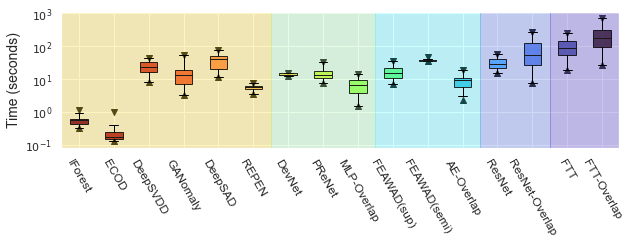

In [89]:
name_list = ['IForest',
             'ECOD',
             'DeepSVDD',
             'GANomaly',
             'DeepSAD',
             'REPEN',
             'DevNet',
             'PReNet',
             'MLP-Overlap',
             'FEAWAD(sup)',
             'FEAWAD(semi)',
             'AE-Overlap',
             'ResNet',
             'ResNet-Overlap',
             'FTT',
             'FTT-Overlap']

fig = plt.figure(figsize=(10, 2.5))
result = np.log10(result_show.astype(float))

box = plt.boxplot(result, showfliers=False, patch_artist=True, medianprops=dict(linewidth=1, color='k'))
colors = cm.turbo_r(np.linspace(0, 1, result.shape[1]))

for patch, color in zip(box['boxes'], colors):
    patch.set(facecolor=color, alpha=0.8)

for i in range(result.shape[1]):
    v_min = np.min(result.iloc[:, i])
    v_max = np.max(result.iloc[:, i])

    plt.scatter(i+1, v_min, marker='^', color='k')
    plt.scatter(i+1, v_max, marker='v', color='k')

plt.xticks(np.arange(result.shape[1])+1, name_list, rotation=-60, fontsize=12)
plt.yticks([-1, 0, 1, 2, 3], ['$10^{-1}$', '$10^0$', '$10^1$', '$10^2$', '$10^3$'])
plt.axvspan(0.5, 6.5, color='gold', alpha=0.25)
plt.axvspan(6.5, 9.5, color='palegreen', alpha=0.25)
plt.axvspan(9.5, 12.5, color='cyan', alpha=0.2)
plt.axvspan(12.5, 14.5, color='royalblue', alpha=0.25)
plt.axvspan(14.5, 16.5, color='slateblue', alpha=0.35)
plt.ylabel('Time (seconds)', fontsize=14)

fig.savefig(os.path.join('time.pdf'), dpi=300, bbox_inches='tight', pad_inches=0.01)

比较不同的overlap loss

In [57]:
def collect_result(metric, la, architecture=None, dataset_list_intersection=None):
    
    # Overlap-Gaussian
    result_ADSD_Gaussian = pd.read_csv(os.path.join('result', 'ablation',
                                                    metric + '_ADSD_proposed_VAE_Gaussian_duplicates(True)_synthetic(None).csv'))
    result_ADSD_Gaussian.rename(columns={'ADSD':'ADSD_Gaussian'}, inplace=True)
    
    # Overlap-Arbitrary
    result_ADSD_Arbitrary = pd.read_csv(os.path.join('result', 'ablation',
                                                     metric + '_ADSD_proposed_' + architecture + '_Arbitrary_duplicates(True)_synthetic(None).csv'))
    result_ADSD_Arbitrary.rename(columns={'ADSD':'ADSD_Arbitrary'}, inplace=True)
    
    # Overlap-Ranking
    result_ADSD_Ranking = pd.read_csv(os.path.join('result', 'ablation',
                                                   metric + '_ADSD_proposed_' + architecture + '_Ranking_duplicates(True)_synthetic(None).csv'))
    result_ADSD_Ranking.rename(columns={'ADSD':'ADSD_Ranking'}, inplace=True)
    
    # Overlap-Arbitrary_Ranking
    result_ADSD_Arbitrary_Ranking = pd.read_csv(os.path.join('result', 'ablation',
                                                             metric + '_ADSD_proposed_' + architecture + '_Arbitrary_Ranking_duplicates(True)_synthetic(None).csv'))
    result_ADSD_Arbitrary_Ranking.rename(columns={'ADSD':'ADSD_Arbitrary_Ranking'}, inplace=True)
    
    # Overlap-ADSD
    result_ADSD = pd.read_csv(os.path.join('result', 'ablation',
                                           metric + '_ADSD_proposed_' + architecture + '_ADSD_duplicates(True)_synthetic(None).csv'))
    
    # merge results
    result = result_ADSD_Gaussian.merge(result_ADSD_Arbitrary, how='left', on='Unnamed: 0')
    result = result.merge(result_ADSD_Ranking, how='left', on='Unnamed: 0')
    result = result.merge(result_ADSD_Arbitrary_Ranking, how='left', on='Unnamed: 0')
    result = result.merge(result_ADSD, how='left', on='Unnamed: 0')
    
    result.rename(columns={'Unnamed: 0':'Params'}, inplace=True)
    
    #整合多次实验结果
    result = result.loc[[ast.literal_eval(_)[1]==la for _ in result['Params']]]
    datasets = list(set([ast.literal_eval(_)[0] for _ in result['Params']]))

    result_show = pd.DataFrame(data=None, index=datasets, columns=result.columns[1:])

    for i,dataset in enumerate(result_show.index):
        #注意这里包含了nan的mean,比如一个模型跑5次实验,其中有一次挂了,在剩余4次有效实验中求平均
        ave_metric = np.nanmean(result.iloc[[ast.literal_eval(_)[0] == dataset for _ in result['Params']],1:], axis=0)
        result_show.iloc[i,:] = ave_metric
    
    # 选择数据集
    data_generator = DataGenerator(generate_duplicates=False, n_samples_threshold=1000)
    
    # 去除样本过少(< 1000)的数据集
    dataset_list = []
    for _ in result_show.index:
        data_generator.seed = 42
        data_generator.dataset = _
        
        data = data_generator.generator(la=1.00)
        if len(data['y_train']) + len(data['y_test']) > 1000:
            dataset_list.append(_)
        else:
            print(f'数据集{_}被移除,样本过少\n')
            
    # exclude 庞老师的数据集
    dataset_list = [_ for _ in dataset_list if _ not in ['3_backdoor', '9_census', '8_celeba', '11_donors', '5_campaign', '13_fraud']]
            
    result_show = result_show.loc[dataset_list, :]
    
    # 有无提供选定的数据集
    if dataset_list_intersection is not None:
        result_show = result_show.loc[dataset_list_intersection, :]
            
    # 输出没有实验结果的数据集+模型
    for i, dataset in enumerate(result_show.index):
        if any(result_show.isna().iloc[i, :].values):
            print(f'Dataset: {dataset}, NaN Model: {list(result_show.columns[result_show.isna().iloc[i, :].values])}')

    #去除没有实验结果的数据集
    result_show.dropna(inplace=True, axis=0)
    
    return result_show

def result_process_final(result_show, name):
    perf = ((result_show.loc[name, 'Perf.'] - result_show.loc[:, 'Perf.']) / result_show.loc[:, 'Perf.']).values
    star = []

    for _ in result_show['p-value']:
        _ = float(_)
        if _ <= 0.01:
            star.append('***')
        elif _ > 0.01 and _ <= 0.05:
            star.append('**')
        elif _ > 0.05 and _ <= 0.1:
            star.append('*')
        else:
            star.append('')
    
    perf = ['+'+str(format(round(_*100, 2), '.2f'))+'%' if _ >= 0 else '-'+str(format(round(_*100, 2), '.2f'))+'%' for _ in perf]
    
    result_show['Perf.'] = [a+b for a, b in zip(perf, star)]
    
    return result_show[['Ave.metric', 'Perf.']]

In [58]:
dataset_list_intersection = ['1_ALOI',
                             '41_Waveform',
                             '20_letter',
                             '44_Wilt',
                             '28_pendigits',
                             '12_fault',
                             '22_magic.gamma',
                             '16_http',
                             '19_landsat',
                             '23_mammography',
                             '7_Cardiotocography',
                             '2_annthyroid',
                             '47_yeast',
                             '26_optdigits',
                             '24_mnist',
                             '32_shuttle',
                             '38_thyroid',
                             '30_satellite',
                             '33_skin',
                             '31_satimage-2',
                             '27_PageBlocks',
                             '35_SpamBase',
                             '25_musk',
                             '40_vowels',
                             '36_speech']

{'Samples': 5393, 'Features': 10, 'Anomalies': 510, 'Anomalies Ratio(%)': 9.46}
数据集33_skin数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 3, 'Anomalies': 2124, 'Anomalies Ratio(%)': 21.24}
{'Samples': 6435, 'Features': 36, 'Anomalies': 2036, 'Anomalies Ratio(%)': 31.64}
{'Samples': 1456, 'Features': 12, 'Anomalies': 50, 'Anomalies Ratio(%)': 3.43}
{'Samples': 4207, 'Features': 57, 'Anomalies': 1679, 'Anomalies Ratio(%)': 39.91}
数据集34_smtp数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 3, 'Anomalies': 2, 'Anomalies Ratio(%)': 0.02}
{'Samples': 1941, 'Features': 27, 'Anomalies': 673, 'Anomalies Ratio(%)': 34.67}
{'Samples': 1484, 'Features': 8, 'Anomalies': 507, 'Anomalies Ratio(%)': 34.16}
{'Samples': 1600, 'Features': 32, 'Anomalies': 100, 'Anomalies Ratio(%)': 6.25}
{'Samples': 5803, 'Features': 36, 'Anomalies': 71, 'Anomalies Ratio(%)': 1.22}
数据集32_shuttle数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 9, 'Anomalies': 736, 'Anomalies Ratio(%)': 7.36}
{'Samples': 1966, 'Features': 1555, 'An

In [122]:
metric = 'AUCPR'
result_show_list = []

for la in [0.05, 0.10, 0.20]:
    for architecture in ['MLP', 'AE', 'ResNet', 'FTTransformer']:
        result_show = collect_result(metric=metric, la=la, architecture=architecture, dataset_list_intersection=dataset_list_intersection)
        result_show = result_show.reindex(sorted(result_show.index, key=lambda x: x.lower()))
        result_show = utils.result_process_new(result_show, 'ADSD', std=False)

        result_show = result_show.loc[['Ave.metric'],:]
        result_show = result_show.transpose()

        result_show.columns = [_ + '_' + architecture + '_' + str(la) for _ in result_show.columns]
        result_show_list.append(result_show)

{'Samples': 5393, 'Features': 10, 'Anomalies': 510, 'Anomalies Ratio(%)': 9.46}
数据集33_skin数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 3, 'Anomalies': 2124, 'Anomalies Ratio(%)': 21.24}
{'Samples': 6435, 'Features': 36, 'Anomalies': 2036, 'Anomalies Ratio(%)': 31.64}
{'Samples': 1456, 'Features': 12, 'Anomalies': 50, 'Anomalies Ratio(%)': 3.43}
{'Samples': 4207, 'Features': 57, 'Anomalies': 1679, 'Anomalies Ratio(%)': 39.91}
数据集34_smtp数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 3, 'Anomalies': 2, 'Anomalies Ratio(%)': 0.02}
{'Samples': 1941, 'Features': 27, 'Anomalies': 673, 'Anomalies Ratio(%)': 34.67}
{'Samples': 1484, 'Features': 8, 'Anomalies': 507, 'Anomalies Ratio(%)': 34.16}
{'Samples': 1600, 'Features': 32, 'Anomalies': 100, 'Anomalies Ratio(%)': 6.25}
{'Samples': 5803, 'Features': 36, 'Anomalies': 71, 'Anomalies Ratio(%)': 1.22}
数据集32_shuttle数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 9, 'Anomalies': 736, 'Anomalies Ratio(%)': 7.36}
{'Samples': 1966, 'Features': 1555, 'An

{'Samples': 1941, 'Features': 27, 'Anomalies': 673, 'Anomalies Ratio(%)': 34.67}
{'Samples': 1484, 'Features': 8, 'Anomalies': 507, 'Anomalies Ratio(%)': 34.16}
{'Samples': 1600, 'Features': 32, 'Anomalies': 100, 'Anomalies Ratio(%)': 6.25}
{'Samples': 5803, 'Features': 36, 'Anomalies': 71, 'Anomalies Ratio(%)': 1.22}
数据集32_shuttle数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 9, 'Anomalies': 736, 'Anomalies Ratio(%)': 7.36}
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
{'Samples': 2114, 'Features': 21, 'Anomalies': 466, 'Anomalies Ratio(%)': 22.04}
{'Samples': 7603, 'Features': 100, 'Anomalies': 700, 'Anomalies Ratio(%)': 9.21}
数据集10_cover数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 10, 'Anomalies': 111, 'Anomalies Ratio(%)': 1.11}
{'Samples': 3062, 'Features': 166, 'Anomalies': 97, 'Anomalies Ratio(%)': 3.17}
{'Samples': 7200, 'Features': 6, 'Anomalies': 534, 'Anomalie

{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
{'Samples': 2114, 'Features': 21, 'Anomalies': 466, 'Anomalies Ratio(%)': 22.04}
{'Samples': 7603, 'Features': 100, 'Anomalies': 700, 'Anomalies Ratio(%)': 9.21}
数据集10_cover数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 10, 'Anomalies': 111, 'Anomalies Ratio(%)': 1.11}
{'Samples': 3062, 'Features': 166, 'Anomalies': 97, 'Anomalies Ratio(%)': 3.17}
{'Samples': 7200, 'Features': 6, 'Anomalies': 534, 'Anomalies Ratio(%)': 7.42}
{'Samples': 6870, 'Features': 16, 'Anomalies': 156, 'Anomalies Ratio(%)': 2.27}
数据集23_mammography数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 6, 'Anomalies': 226, 'Anomalies Ratio(%)': 2.26}
数据集1_ALOI数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 27, 'Anomalies': 302, 'Anomalies Ratio(%)': 3.02}
数据集16_http数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 3, 'Anomalies': 54, 'Anomalies Ratio(%)': 0.54}
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
{'Samples': 5

{'Samples': 6870, 'Features': 16, 'Anomalies': 156, 'Anomalies Ratio(%)': 2.27}
数据集23_mammography数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 6, 'Anomalies': 226, 'Anomalies Ratio(%)': 2.26}
数据集1_ALOI数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 27, 'Anomalies': 302, 'Anomalies Ratio(%)': 3.02}
数据集16_http数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 3, 'Anomalies': 54, 'Anomalies Ratio(%)': 0.54}
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
{'Samples': 5216, 'Features': 64, 'Anomalies': 150, 'Anomalies Ratio(%)': 2.88}
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
数据集22_magic.gamma数据量过大, 正在抽样...
{'Samples': 10000, 'Features': 10, 'Anomalies': 3508, 'Anomalies Ratio(%)': 35.08}
{'Samples': 6435, 'Features': 36, 'Anomalies': 1333, 'Anomalies Ratio(%)': 20.71}
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
{'Samples': 3443, 'Features': 21, 'Anomalies': 100, 'Anomalies Ratio(%)': 2.9}
{'Samp

In [123]:
result = pd.concat(result_show_list, axis=1)

In [124]:
result

,Ave.metric_MLP_0.05,Ave.metric_AE_0.05,Ave.metric_ResNet_0.05,Ave.metric_FTTransformer_0.05,Ave.metric_MLP_0.1,Ave.metric_AE_0.1,Ave.metric_ResNet_0.1,Ave.metric_FTTransformer_0.1,Ave.metric_MLP_0.2,Ave.metric_AE_0.2,Ave.metric_ResNet_0.2,Ave.metric_FTTransformer_0.2
ADSD_Gaussian,0.159,0.159,0.159,0.159,0.158,0.158,0.158,0.158,0.158,0.158,0.158,0.158
ADSD_Arbitrary,0.349,0.376,0.341,0.356,0.376,0.416,0.407,0.339,0.397,0.410,0.426,0.352
ADSD_Ranking,0.535,0.558,0.539,0.623,0.605,0.620,0.625,0.687,0.657,0.657,0.691,0.731
ADSD_Arbitrary_Ranking,0.624,0.642,0.604,0.418,0.682,0.695,0.686,0.439,0.708,0.719,0.741,0.459
ADSD,0.623,0.652,0.627,0.627,0.674,0.695,0.699,0.686,0.696,0.713,0.742,0.730


In [125]:
result.to_csv('ablation_AUCPR.csv', index=True, encoding='gbk')